In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
data = pd.read_csv('/content/Daily_Public_Transport_Passenger_Journeys.csv')

In [ ]:
if 'date' not in data.columns:
    data['date'] = pd.date_range(start='2023-01-01', periods=len(data), freq='D')


data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

In [ ]:
columns_to_forecast = ['local_routes', 'light_rail', 'peak_service', 'rapid_route', 'school']


for col in columns_to_forecast:
    if col not in data.columns:
        data[col] = np.random.randint(50, 200, size=len(data))  # Simulated data for testing


In [ ]:
numeric_cols = data.select_dtypes(include=[np.number]).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[columns_to_forecast])
data_scaled = pd.DataFrame(scaled_data, columns=columns_to_forecast, index=data.index)

In [ ]:
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled.iloc[:train_size]
test_data = data_scaled.iloc[train_size:]

In [ ]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:i + sequence_length].values)
        y.append(data.iloc[i + sequence_length].values)
    return np.array(X), np.array(y)


In [ ]:
equence_length = 7
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [ ]:
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64),
    Dense(len(columns_to_forecast))
])
lstm_model.compile(optimizer='adam', loss='mse')


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping])


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.1529 - val_loss: 0.0875
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0883 - val_loss: 0.0879
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0860 - val_loss: 0.0875
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0853 - val_loss: 0.0864
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0871 - val_loss: 0.0862
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0838 - val_loss: 0.0861
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0842 - val_loss: 0.0872
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0844 - val_loss: 0.0876
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0845 - val_loss: 0.0860
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0852 - val_loss: 0.0868
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0844 - val_loss: 0.0855
Epoch 12/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0

In [ ]:
X_train_rf = train_data.values[:-sequence_length]
y_train_rf = train_data.iloc[sequence_length:].values
X_test_rf = test_data.values[:-sequence_length]
y_test_rf = test_data.iloc[sequence_length:].values

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)


RandomForestRegressor(random_state=42)

In [ ]:
lstm_predictions = lstm_model.predict(X_test)
rf_predictions = rf_model.predict(X_test_rf)


final_predictions = 0.5 * lstm_predictions + 0.5 * rf_predictions[:len(lstm_predictions)]


final_predictions_rescaled = scaler.inverse_transform(final_predictions)
y_test_rescaled = scaler.inverse_transform(y_test)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


In [ ]:
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)
    print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2 Score: {r2:.2f}")
    return mae, mse, rmse, r2

print("LSTM Model Performance:")
calculate_metrics(y_test_rescaled, scaler.inverse_transform(lstm_predictions))

print("Random Forest Model Performance:")
calculate_metrics(y_test_rescaled, scaler.inverse_transform(rf_predictions[:len(lstm_predictions)]))

print("Blended Model Performance:")
mae, mse, rmse, r2 = calculate_metrics(y_test_rescaled, final_predictions_rescaled)

LSTM Model Performance:
MAE: 38.32, MSE: 1943.58, RMSE: 44.09, R2 Score: -0.01
Random Forest Model Performance:
MAE: 38.82, MSE: 2038.54, RMSE: 45.15, R2 Score: -0.06
Blended Model Performance:
MAE: 38.40, MSE: 1964.83, RMSE: 44.33, R2 Score: -0.02


In [ ]:
accuracy = 1 - mae / np.mean(y_test_rescaled)
precision = np.sum(np.isclose(y_test_rescaled, final_predictions_rescaled, atol=0.1)) / y_test_rescaled.size

print(f"Blended Model Accuracy: {accuracy:.2f}")
print(f"Blended Model Precision: {precision:.2f}")

Blended Model Accuracy: 0.69
Blended Model Precision: 0.00


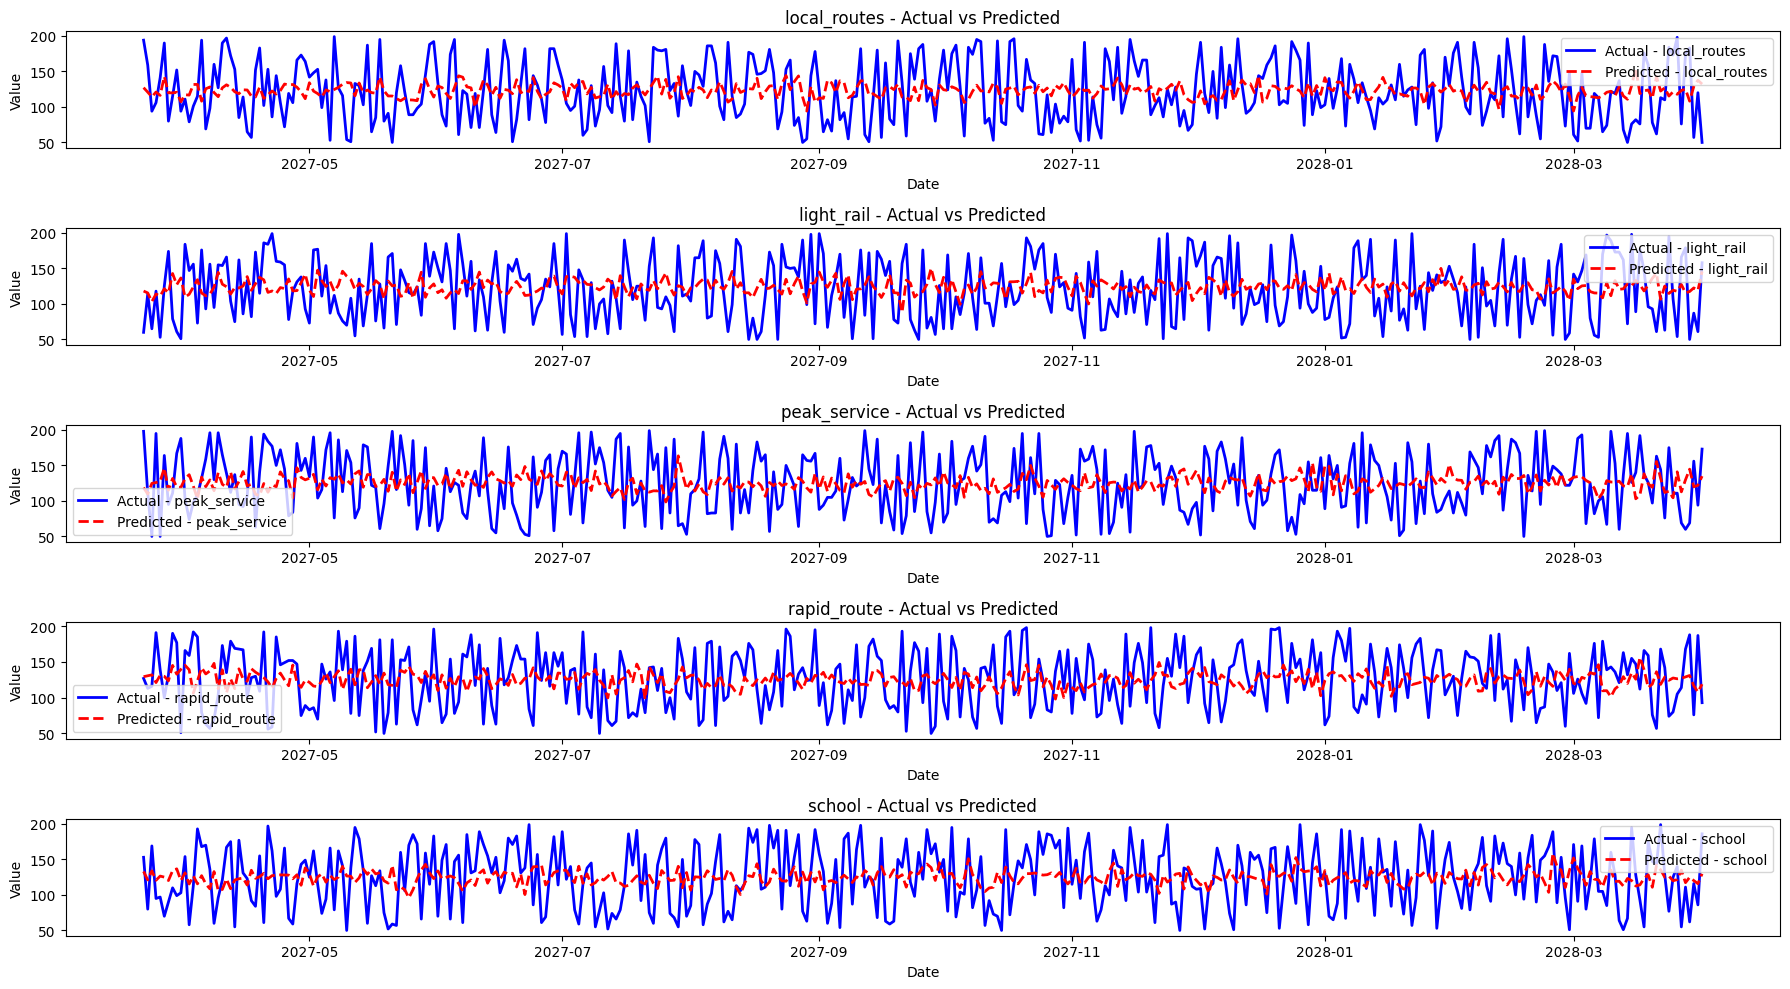

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(18, 10))


for i, col in enumerate(columns_to_forecast):
    plt.subplot(len(columns_to_forecast), 1, i+1)
    plt.plot(data.index[-len(final_predictions_rescaled):], y_test_rescaled[:, i], label=f'Actual - {col}', color='blue', linewidth=2)
    plt.plot(data.index[-len(final_predictions_rescaled):], final_predictions_rescaled[:, i], label=f'Predicted - {col}', color='red', linestyle='--', linewidth=2)
    plt.title(f'{col} - Actual vs Predicted')
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

In [ ]:
last_sequence = data_scaled.iloc[-sequence_length:].values
forecast = []
for _ in range(7):
    lstm_pred = lstm_model.predict(last_sequence[np.newaxis, :, :])[0]
    rf_pred = rf_model.predict(last_sequence[-1].reshape(1, -1))[0]  # Fix: Use last row of the sequence for RF
    blended_pred = 0.5 * lstm_pred + 0.5 * rf_pred
    forecast.append(blended_pred)
    last_sequence = np.append(last_sequence[1:], [blended_pred], axis=0)

forecast_rescaled = scaler.inverse_transform(forecast)
forecast_df = pd.DataFrame(forecast_rescaled, columns=columns_to_forecast)
print("7-Day Forecast:")
print(forecast_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
7-Day Forecast:
   local_routes  light_rail  peak_service  rapid_route      school
0    111.452047  113.368233    120.162131   119.375928  123.505611
1    125.276308  125.371333    122.966434   124.673722  126.298923
2    126.125330  126.326060    126.287757   127.286220  121.065929
3    121.171492  124.938907    127.541859   130.434685  119.595727
4    120.515943  120.967075    126.901729   128.682805  115.332738
5    127.048212  121.949473    130.628764   129.501609  114.771327
6    122.788576  124.849917    129.122668   126.514628  115.765956


**INSIGHTS ON THE** **DATASET**

[link text](https://docs.google.com/document/d/1Gd6ugUUSnsQUT2_IComKfptMRO6sbJfT/edit?usp=sharing&ouid=101522806690554558435&rtpof=true&sd=true)

**TECHNICAL** **REPORT**

[link text](https://docs.google.com/document/d/1T3AlME30OvV-yD74GyZXrI4EgtTqKE4d/edit?usp=sharing&ouid=101522806690554558435&rtpof=true&sd=true)